In [1]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# loading the xtc and gro file into mdtraj
traj = md.load('eql2.xtc', top='conf.gro')

In [3]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in range(nframes):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

(51, 592, 3)


In [4]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in range(nframes):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

51


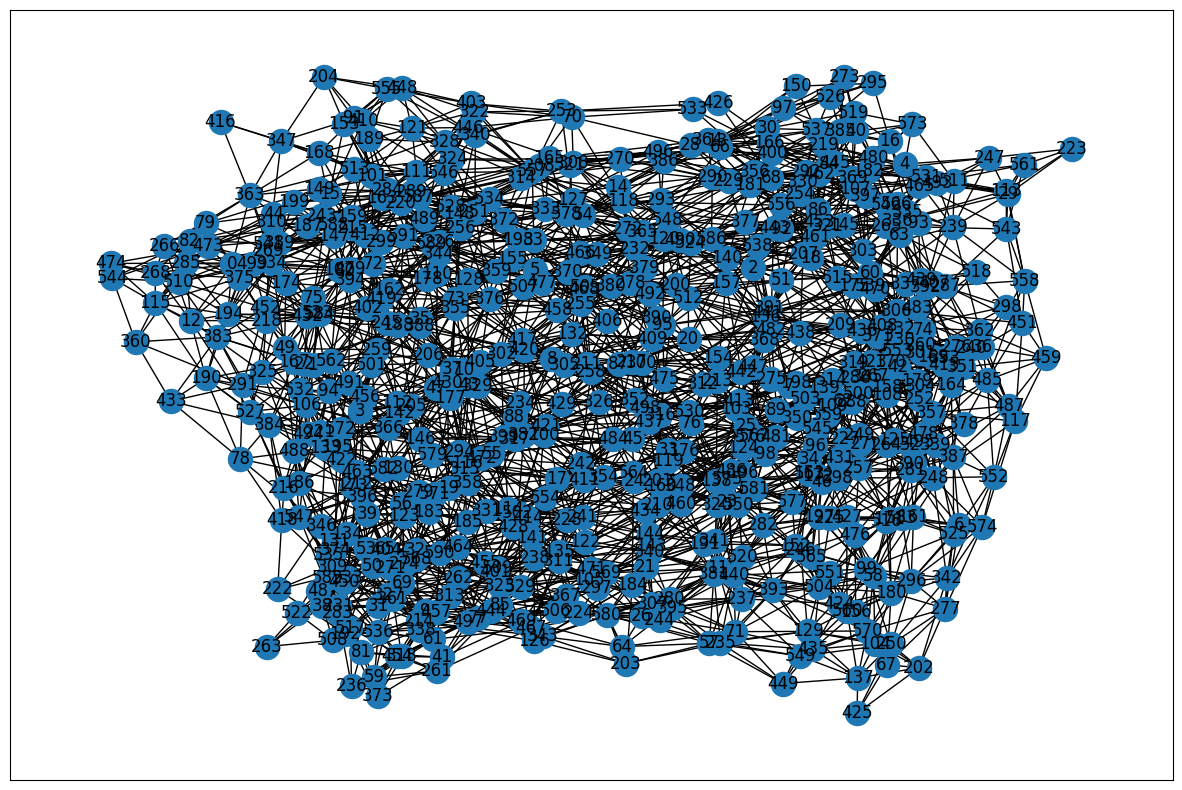

In [5]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [6]:
graphs = []
for frame in range(nframes):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

Data(x=[592, 3], edge_index=[2, 7968], y=[1])


In [7]:
# import model.
from model import *

In [8]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
from pytorch3d.loss import chamfer_distance

In [10]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [11]:
for data in train_loader_set:
    z,encoded_edgeindex=model.encode(data.x,data.edge_index)
    decodedx,decoded_edgeindex=model.decode(z,encoded_edgeindex)
    # print(data)
    print(decodedx)
    print("data.x")
    print(data.x)
    print("sizes")
    print(decodedx.size())
    print(data.x.size())

tensor([[-0.0364, -0.0094, -0.0598],
        [-0.0123, -0.0344,  0.0277],
        [-0.0018, -0.0023, -0.0015],
        ...,
        [-0.0253, -0.0120, -0.0324],
        [-0.0869, -0.0450, -0.1049],
        [-0.0158, -0.0033, -0.0272]], grad_fn=<SiluBackward0>)
data.x
tensor([[1.2075, 0.0610, 0.1970],
        [1.7150, 0.4753, 1.1825],
        [0.5010, 0.3520, 0.4270],
        ...,
        [1.4815, 1.9358, 1.2370],
        [0.4125, 1.4688, 2.0345],
        [1.3463, 1.3150, 1.0228]])
sizes
torch.Size([592, 3])
torch.Size([592, 3])
tensor([[ 0.0045,  0.0061, -0.0023],
        [-0.0499, -0.0336, -0.0489],
        [-0.0164,  0.0021, -0.0370],
        ...,
        [-0.0047,  0.0019, -0.0139],
        [-0.0105, -0.0083, -0.0084],
        [-0.0023, -0.0084,  0.0068]], grad_fn=<SiluBackward0>)
data.x
tensor([[1.5780, 1.4200, 0.2418],
        [1.2730, 1.9433, 0.8568],
        [0.6438, 0.8598, 1.2458],
        ...,
        [0.9643, 0.8875, 0.9375],
        [1.2493, 0.1208, 1.2738],
        [2.2815

In [12]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [13]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []
cd_losses=[]
for epoch in range(1, epochs+ 1):
    total_loss, cd_loss,feature_loss, edge_loss, kl_loss = train()
    print(f'Epoch: {epoch:03d}')
    print(f'TRAIN : Total Loss: {total_loss:.4f}, CD Loss : {cd_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    cd_losses.append(cd_loss)
   

/tmp/ipykernel_23499/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)


Epoch: 001
TRAIN : Total Loss: 8.8597, CD Loss : 6.5368, Feature Loss: 2.3228, Edge Loss: 0.0000
Epoch: 002
TRAIN : Total Loss: 8.7845, CD Loss : 6.4716, Feature Loss: 2.3129, Edge Loss: 0.0000
Epoch: 003
TRAIN : Total Loss: 8.7753, CD Loss : 6.4755, Feature Loss: 2.2998, Edge Loss: 0.0000
Epoch: 004
TRAIN : Total Loss: 8.7574, CD Loss : 6.4657, Feature Loss: 2.2918, Edge Loss: 0.0000
Epoch: 005
TRAIN : Total Loss: 8.7208, CD Loss : 6.4396, Feature Loss: 2.2813, Edge Loss: 0.0000
Epoch: 006
TRAIN : Total Loss: 8.6743, CD Loss : 6.4086, Feature Loss: 2.2656, Edge Loss: 0.0000
Epoch: 007
TRAIN : Total Loss: 8.6003, CD Loss : 6.3461, Feature Loss: 2.2543, Edge Loss: 0.0000
Epoch: 008
TRAIN : Total Loss: 8.5956, CD Loss : 6.3478, Feature Loss: 2.2478, Edge Loss: 0.0000
Epoch: 009
TRAIN : Total Loss: 8.5140, CD Loss : 6.2800, Feature Loss: 2.2340, Edge Loss: 0.0000
Epoch: 010
TRAIN : Total Loss: 8.4944, CD Loss : 6.2713, Feature Loss: 2.2231, Edge Loss: 0.0000
Epoch: 011
TRAIN : Total Loss:

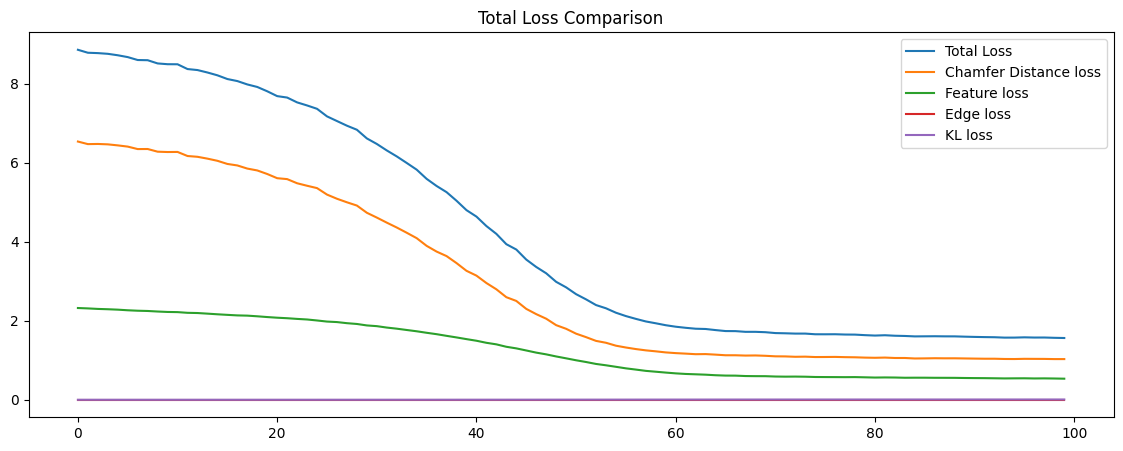

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(feature_losses, label='Feature loss')
plt.plot(edge_losses, label='Edge loss')
plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.title('Total Loss Comparison')
plt.show()

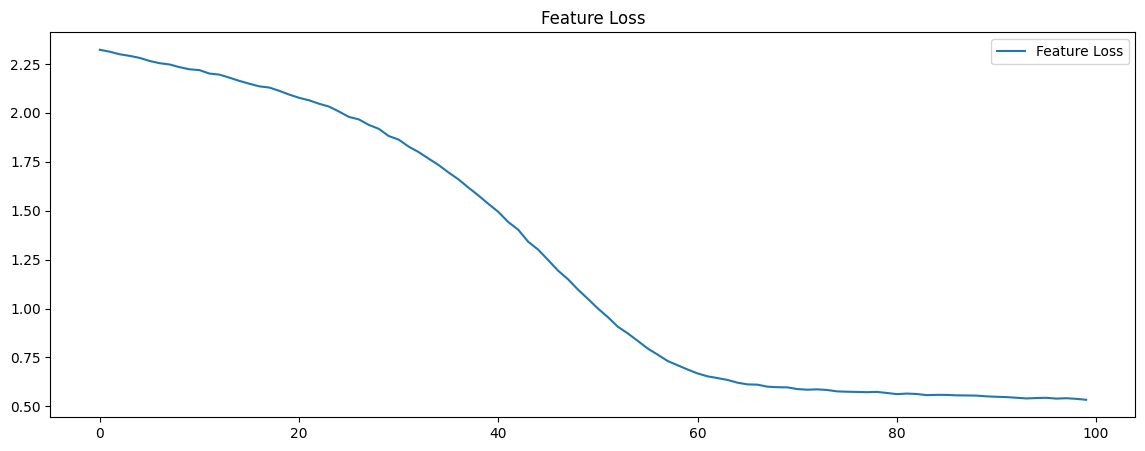

In [15]:

plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()

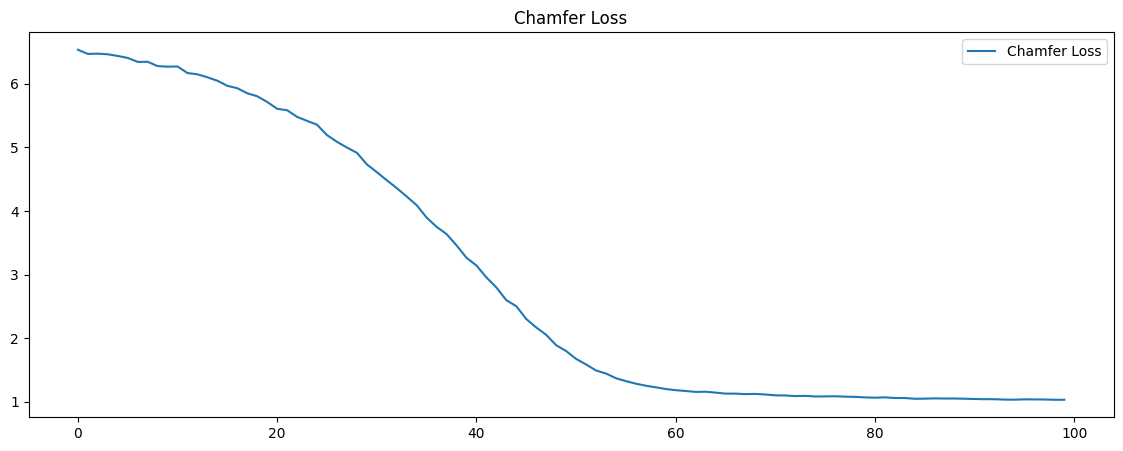

In [16]:

plt.figure(figsize=(14, 5))
plt.plot(cd_losses, label='Chamfer Loss')
plt.legend()
plt.title('Chamfer Loss')
plt.show()